# NOTE: These notebooks are designed to be ran in colab

# The Dataset

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [19]:
import pandas as pd

df = pd.read_csv(CSV_PATH)
df = df.drop('DPOR', axis=1) # DPOR is a purely derived quantity
df.head()

,Depth,RxoRt,RLL3,SP,RILD,MN,MI,MCAL,DCAL,RHOB,RHOC,CNLS,GR
0,195.0,226.0848,0.4076,69.8953,132.5052,-0.3548,0.1863,5.1090,1.8878,1.6973,-0.6303,30.0657,60.4576
1,195.5,223.5031,0.4063,69.2303,123.6225,-0.3619,0.1867,5.1031,1.8882,1.6791,-0.6409,26.7625,54.1495
2,196.0,221.4560,0.4047,68.4478,116.9258,-0.3668,0.1860,5.0872,1.8878,1.6585,-0.6539,27.6017,51.9944
3,196.5,219.8248,0.4033,67.4843,111.7925,-0.3613,0.1867,5.0881,1.8884,1.6435,-0.6649,31.5870,52.9645
4,197.0,218.1438,0.4023,66.3013,106.7821,-0.3569,0.1870,5.0972,1.8883,1.6390,-0.6705,35.8251,54.9659


# MLP Regression Network

In [42]:
import tensorflow as tf
import keras
from keras import layers
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

# Extract labels RHOB and CNLS
Y = df[["RHOB", "CNLS"]].to_numpy()

# Extract features
X = df.drop(["RHOB", "CNLS"], axis=1).to_numpy()

scalerX = StandardScaler()
scalerY = StandardScaler()

X_scaled = scalerX.fit_transform(X)
Y_scaled = scalerY.fit_transform(Y)

print(X.shape)
print(Y.shape)

model = keras.Sequential(
    [
        layers.Input(shape=(X.shape[1],)),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(2, activation="linear")
    ]
)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model.summary()

(8739, 11)
(8739, 2)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,058 (19.76 KB)

 Trainable params: 5,058 (19.76 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
model.fit(X_scaled, Y_scaled, validation_split=0.2, epochs=100, batch_size=32)

model.save_weights("model.weights.h5")


Y_pred_scaled = model.predict(X_scaled)
Y_pred = scalerY.inverse_transform(Y_pred_scaled)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0491 - mae: 0.1469 - val_loss: 0.2449 - val_mae: 0.3566
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0544 - mae: 0.1544 - val_loss: 0.2520 - val_mae: 0.3625
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0504 - mae: 0.1501 - val_loss: 0.2685 - val_mae: 0.3920
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0494 - mae: 0.1471 - val_loss: 0.2721 - val_mae: 0.3790
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0514 - mae: 0.1494 - val_loss: 0.2692 - val_mae: 0.3788
Epoch 6/100
 56/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0503 - mae: 0.1497

KeyboardInterrupt: 

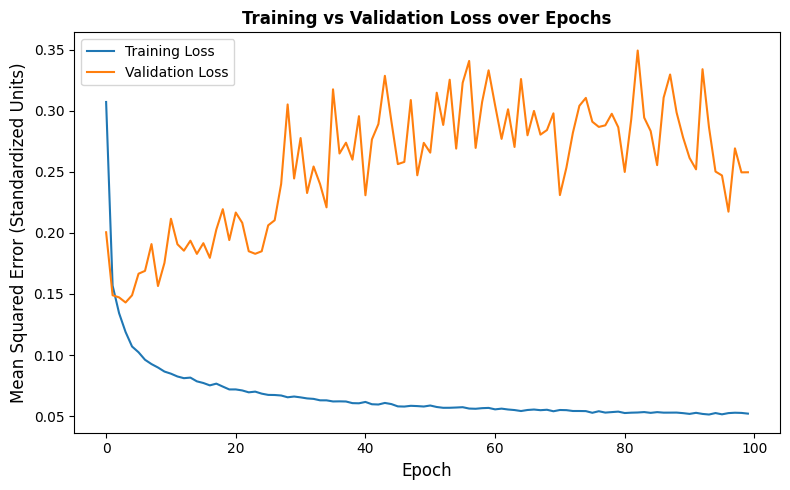

In [49]:
plt.figure(figsize=(8, 5))
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')

plt.title('Training vs Validation Loss over Epochs', fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Squared Error (Standardized Units)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()
